# Data Forecasting with prophet


# PROPHET PREDICTION

## TESTO

## Import Dependencies

In [ ]:
!pip3 install chart_studio
!pip3 install pystan
!pip3 install fbprophet
!pip3 install glob2
!pip3 install python-dateutil

In [2]:
import os
import itertools
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import time
import datetime 
from datetime import timedelta
import math
import numpy as np
import scipy.stats as st
from prophet import Prophet
from influxdb_client import InfluxDBClient
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller

In [8]:
INFLUXDB_HOST = os.getenv("INFLUX_HOST")
INFLUXDB_PORT = os.getenv("INFLUX_HOST_PORT")
INFLUXDB_ORG = os.getenv("INFLUX_ORG")
INFLUXDB_TOKEN = os.getenv("INFLUX_TOKEN")
client = InfluxDBClient(url="http://"+INFLUXDB_HOST+":"+INFLUXDB_PORT, token=INFLUXDB_TOKEN, org=INFLUXDB_ORG)


In [9]:
def convert_to_dataframe(result):
    raw = []
    for table in result:
        for record in table.records:
            raw.append((record.get_time(), record.get_value()))
    return pd.DataFrame(raw, columns=['ds','y'], index=None)

In [10]:
#buckets = [ 'temperature', 'humidity', 'gas']
buckets = ["gas"]

In [20]:
#With this function we obtain the forecasted data

def bucket_forecast(bucket):
    global mse_array
    global forecasted_array
    global expected_array
    global forecasted
    global expected
    global forecast

    mse_array = []
    forecasted_array = []
    expected_array = []
    forecasted = []
    expected = []
    
    print(bucket)
    query = 'from(bucket: "'+ bucket +'")' \
                ' |> range(start:-30d)'\
                ' |> filter(fn: (r) => r["_measurement"] == "val")' \
                ' |> filter(fn: (r) => r["_field"] == "' + bucket +'")' \
                ' |> aggregateWindow(every: 3m , fn: mean, createEmpty: false)'\
                ' |> yield(name: "mean")'\

    result = client.query_api().query(org=INFLUXDB_ORG, query=query)
    # Convert the results to dataframe
    df = convert_to_dataframe(result)
    print(df)
    df['ds'] = df['ds'].dt.tz_localize(None)

    #train_size 80% - test_size 20%

    train, test = train_test_split(df, test_size=0.2, shuffle=False)
    m = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=30,
        n_changepoints=35,
        changepoint_range=1,
        changepoint_prior_scale=0.01
    ).fit(train)
    
    test_interval = int((test.iloc[-1]['ds'].timestamp() - test.iloc[0]['ds'].timestamp()) / 60)
    test_interval = test_interval + 5
    #print(test_interval)

    future = m.make_future_dataframe(periods=test_interval, freq= DateOffset(minutes=1))
    forecast = m.predict(future)

    forecast['ds'] = forecast.ds.dt.floor('min')
    test['ds'] = test.ds.dt.floor('min')
    metric = test.set_index('ds')[['y']].join(forecast.set_index('ds').yhat).reset_index()

    metric = metric.dropna()
    
    mse = mean_squared_error(metric['y'], metric['yhat'])
    mse_array.append(mse)
    
    expected_array.append(metric['y'].tolist())
    forecasted_array.append(metric['yhat'].tolist())
    forecasted = list(itertools.chain.from_iterable(forecasted_array))
    expected = list(itertools.chain.from_iterable(expected_array))

    

# evaluate_field('temp')
# print(mse_array)
# print(sum(mse_array)/len(mse_array))

In [15]:
from influxdb_client import InfluxDBClient, Point, WriteOptions
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client.client.write_api import WriteType

gas
                           ds          y
0   2022-10-06 09:36:00+00:00  11.262295
1   2022-10-06 09:39:00+00:00  11.671875
2   2022-10-06 09:42:00+00:00  12.296875
3   2022-10-06 09:45:00+00:00  11.876923
4   2022-10-06 09:48:00+00:00  10.953125
..                        ...        ...
919 2022-10-11 09:30:00+00:00   0.000000
920 2022-10-06 09:36:00+00:00  11.303333
921 2022-10-06 09:39:00+00:00  11.886667
922 2022-10-06 09:42:00+00:00  12.346667
923 2022-10-06 09:45:00+00:00  12.550000

[924 rows x 2 columns]


19:31:07 - cmdstanpy - INFO - Chain [1] start processing
19:31:08 - cmdstanpy - INFO - Chain [1] done processing




Evaluating gas


C:\Users\andre\AppData\Local\Temp\ipykernel_2500\3858582355.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ds'] = test.ds.dt.floor('min')


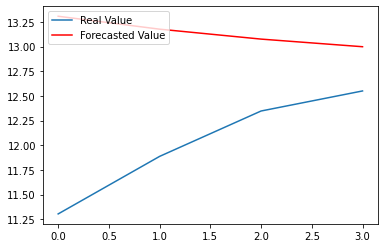

mse
1.602778973279284
Test RMSE: 1.266
MAE: 1.117682
Mean:  13.1393488859336
Standard Deviation:  0.11568190748987645
Confidence intervals:  (12.926796541931559, 13.351901229935642)
['13.30729067854627', '13.176249551065025', '13.075546912890516', '12.998308401232588', '12.936319062419713', '12.8820637121973', '12.83033032321592', '12.779114436347841', '12.729703937245036', '12.68598004541843', '12.653115204604603', '12.635957385193212', '12.637445233683739', '12.657390759245914', '12.691897704742116', '12.733566358685561', '12.77248949782315', '12.797894387750485', '12.800158066756579', '12.77283984380457', '12.714351254577833', '12.62892523105609', '12.526647838731076', '12.422462553195574', '12.334225890258018', '12.280057324968176', '12.275358865336866', '12.329957902073112', '12.445836413013414', '12.615846166407055', '12.823680549038789', '13.045196650142016', '11.880509995521916', '11.404785224794384', '10.959730052488679', '10.581087070021777', '10.29689958653351', '10.12426321

In [21]:
APE = []
i = 0
for bucket in buckets:
	bucket_forecast(bucket)
	print("\n\nEvaluating " + bucket)
	plt.plot(expected, label="Real Value")
	plt.plot(forecasted, "-r", label="Forecasted Value")

	plt.legend(loc="upper left")
	plt.show()

	#Mean Square Error & Root Square Error considered more accurate 
	mse = mean_squared_error(expected, forecasted)
	print('mse')
	print(mse) #mah
	rmse = math.sqrt(mean_squared_error(expected, forecasted))
	print('Test RMSE: %.3f'%rmse)

	
	# MAE
	# The mean absolute error, or MAE, 
	# is calculated as the average of the forecast error values, 
	# where all of the forecast error values are forced to be positive.
	# These error values are in the original units of the predicted values. 
	# A mean absolute error of zero indicates no error.

	# Calculate the MAE 
	mae = mean_absolute_error(expected, forecasted)
	print('MAE: %f' % mae)


	# A confidence interval is an estimation technique used in statistical inference to constrain a pair or pairs of values, 
	# within which the desired point estimate will be found (with a certain probability).

	# A confidence interval will allow us to calculate two values around a sample mean (one upper and one lower). 
	# These values will bound an interval within which, with some probability, the population parameter will be found.


	mean = sum(forecasted) / len(forecasted) #mean
	print("Mean: ",mean)


	std = np.std(forecasted)  # standard deviation
	print("Standard Deviation: ",std)

	# create 95% confidence interval
	res = st.t.interval(alpha=0.95, df=len(forecasted)-1,
				loc=np.mean(forecasted),
				scale=st.sem(forecasted))

	print("Confidence intervals: ",res)

	lines = [str(forecast["yhat"][d]) for d in range(len(forecast))]
	print(lines)
	lines = ['val,prediction=yes,clientId=' + str("diubi-esp-32")+",lat=999,lng=999"+ " " + bucket + '=' + str(forecast["yhat"][d])
									+ ' ' + str(int(time.mktime(forecast['ds'][d].timetuple())) + 3600*2) + "000000000" for d in range(len(forecast))]
	write_client = client.write_api(write_options=WriteOptions(batch_size=1000, flush_interval=10_000,
															jitter_interval=2_000, retry_interval=5_000, write_type=WriteType.synchronous))
	write_client.write(bucket, INFLUXDB_ORG, lines)